# Hot Jupiter Analysis

__If you make use of this code, please cite Christ, C. N., Montet, B. T., & Fabrycky, D. C. 2018, arXiv:1810.02826__

The following code analyzes whether or not TESS will be able to detect tidal orbital decay in hot Jupiter systems and what tidal parameter quality factor each system must have in order to make tidal orbital decay detectable, thus (possibly) allowing us to estimate the interior structure of the central stars

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman 
from scipy.interpolate import interp1d

In [ ]:
#reading in dataframe from TESS sensitivity analysis (table of detectable planets in 2 sectors)
df_prob2 = pd.read_csv('prob_of_detection_camp2.csv')
df_prob_small = df_prob2[df_prob2['koi_prad']<=30]
#print(df_prob2)
#print(df_prob_small)

In [4]:
#calculating transit time in July with a constant period model
#using error propagation to figure out the Kepler errors in July
dict_july_transits = {}
for index, row in df_prob2.iterrows():
    period = row['koi_period']
    perioderr1 = row['koi_period_err1']
    first_epoch_time = row['koi_time0bk']
    
    #July 15th, 2019 - Jan 1st, 2009 (units BKJD- days from Jan 1st 2009)
    T0 = 2458679.5 - 2454833.0 
    T0_err1 = row['koi_time0bk_err1']
    
    #getting counts for how many epochs have occured from initial epoch to July 15th, 2019
    k=1
    while ((first_epoch_time + period*k) <= T0):
        k+=1
    E = k-1
    
    #finding transit uncertainty with kepler
    C = first_epoch_time + period*E  
    delta_C = np.sqrt(T0_err1**2 + (perioderr1*E)**2)
    delta_C *= 1440
    
    df_prob2.at[index, 'Transit_uncert'] = delta_C #in minutes
    df_prob2.at[index, 'Constant_period_transit_time'] = C
    df_prob2.at[index, 'Epoch_num_july19'] = E
    dict_july_transits[row['kepoi_name']] = delta_C 

In [ ]:
df_transit_uncert = pd.DataFrame.from_dict(dict_july_transits, orient='index')
#print(df_transit_uncert.isnull().sum())  #counting number of nan values for transit uncert

In [6]:
#looking at orbital decay for all of these detectable planets using eqn from Patra et al.'s 2017 paper
dict_change_in_p = {}
for index, row in df_prob2.iterrows():
    radius = row['koi_prad']                        #in radius of earth
    semi_axis_srad = row['koi_sma']*214.93946938362 #now in solar radii
    mass_star = row['koi_smass']
    mass_star_earthm = mass_star*334672.021419      #now in earth masses
    change_p_lst = []
    
    #trying different typical Q_star values
    for i in range(3, 8):
        if (radius >= 8.0):  
            #treat as a jupiter sized mass 
            #317.8 is mass of jupiter in earth masses
            change_p = (-27*np.pi) / (2*(float(1*10**i))) * (317.8 / mass_star_earthm)*(row['koi_srad'] / semi_axis_srad)**5
            change_p_lst.append(change_p)
        else:
            #M_planet = (radius / 1)**(2.06)  #this is when we used mass radius relationship to calculate mass
            change_p = (-27*np.pi) / (2*(float(1*10**i))) * (317.8 / mass_star_earthm)*(row['koi_srad'] / semi_axis_srad)**5
            change_p_lst.append(change_p)
            
    df_prob2.at[index, 'change_p'] = change_p_lst[0]
    dict_change_in_p[row['kepoi_name']] = change_p_lst       

In [7]:
df_change_p = pd.DataFrame.from_dict(dict_change_in_p, orient='index')

In [8]:
#calculating times of transit based on an orbital decay model in July 2019
for index, row in df_prob2.iterrows():
    C_transits = row['Constant_period_transit_time']
    T0 = row['koi_time0bk']                           #initial time of transit (days after Jan 1st)
    period = row['koi_period']
    change_p = row['change_p']
    N = row['Epoch_num_july19']                       #N is number of transits after inital transit in July 2019
    Tn = T0 + N*period + 0.5*(N**2)*change_p*period   #(chance_p*period = change in period in one orbit)
    df_prob2.at[index, 'decay_transit_in_july19'] = Tn
    df_prob2.at[index, 'Transit_difference'] = (C_transits - Tn)*1440

In [ ]:
#removing some planets that were falsely labelled 
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05129.01']
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05157.01'] 
testing_vals = ['K00002.01', 'K00013.01', 'K01075.01', 'K03156.01', 'K05220.01', 'K05353.01', 'K07259.01']
df_prob2 = df_prob2[(df_prob2['kepoi_name']).isin(testing_vals)]
plt.hist(df_prob2['Transit_difference'], np.arange(1, 100, 1))
plt.show()

'''
df_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K00977.01']  #bad
#print(df_prob2)
df_prob9 = df_prob2[df_prob2['kepoi_name'] == 'K07430.01']  #good
print(df_prob9)
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K00971.01'] #bad
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K01140.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05220.01'] #keep
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07791.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07100.01']
#df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K05157.01'] #toss this one

outliers = df_prob2[df_prob2['Transit_difference'] >= 2000]
'''

In [13]:
#finding the tess uncertainty the same way as in the batman lightcurve notebook
for index, row in df_prob2.iterrows():
    M_star = row['koi_smass']
    Period = row['koi_period']
    a_axis_au = row['koi_sma']
    radius_p = row['koi_prad']
    radius_s = row['koi_srad']
    
    a_axis_stellar_r = a_axis_au*214.93946938362 / radius_s
    bat_params = batman.TransitParams()
    bat_params.t0 = 0.
    bat_params.per = Period
    bat_params.rp = radius_p / 109.489447246618 / radius_s    #planet radius (in units of stellar radii), converting from R_earth to R_star
    bat_params.a = a_axis_stellar_r                           #semi-major axis (in units of stellar radii)
    bat_params.inc = 90 #row['koi_incl']
    bat_params.ecc = row['koi_eccen']
    bat_params.w = 90 #row['koi_longp']                       #longitude of periastron (in degrees)
    bat_params.u = [0.2075, 0.3785]
    bat_params.limb_dark = "quadratic"
    
    num_transits = int(30.0 / Period)
    if (num_transits == 0):
        two_min_x = np.arange(-Period/2, Period/2, 0.00138889)
    else:
        two_min_x = np.arange(-Period/2, Period/2, 0.00138889/num_transits)
        
        
    #initalizing batman model    
    b_model = batman.TransitModel(bat_params, two_min_x, supersample_factor=7, exp_time=0.00138889) 
    flux = b_model.light_curve(bat_params)
    
    t_contam_ratio = 1 / (1 + row['tess_contam_ratio'])
    #flux = flux*(row['kep_contam_ratio'])  
    
    #figuring out the transit duration in days (koi_duration is in hrs)
    duration = row['koi_duration'] / 24
  
    np.random.seed(6)
    noise = row['tot_noise']
    flux_uncert = np.random.normal(0, np.sqrt(15)*noise*10**(-6), len(two_min_x))    
    new_y = flux + flux_uncert
    
    t0_array = np.linspace(-1*(duration+0.15), duration+0.15, 5000)
    t0_vs_chi2 = np.zeros(shape=(len(t0_array), 2))
    
    
    for time in range(len(t0_array)):
        a_axis_stellar_r = a_axis_au*214.93946938362 / radius_s
        bat_params = batman.TransitParams()
        bat_params.t0 = t0_array[time]
        bat_params.per = Period
        bat_params.rp = radius_p / 109.489447246618 / radius_s    #planet radius (in units of stellar radii) #converting from R_earth to R_star
        bat_params.a = a_axis_stellar_r                           #semi-major axis (in units of stellar radii)
        bat_params.inc = 90 #row['koi_incl']
        bat_params.ecc = row['koi_eccen']
        bat_params.w = 90    #row['koi_longp']                    #longitude of periastron (in degrees)
        bat_params.u = [0.2075, 0.3785]
        bat_params.limb_dark = "quadratic"
        
        b_model = batman.TransitModel(bat_params, two_min_x, supersample_factor=7, exp_time=0.00138889)#!0.02083
        flux = b_model.light_curve(bat_params)

        t_contam_ratio = 1 / (1 + row['tess_contam_ratio'])
        flux = flux*t_contam_ratio    
       
        residuals = (flux - new_y)**2 
        chi2 = residuals / (np.sqrt(15)*noise*10**(-6))**2  
        
        t0_vs_chi2[time, 0] = t0_array[time]
        t0_vs_chi2[time, 1] = np.sum(chi2)
        
    
    likelihood_array = np.zeros(shape=(len(t0_vs_chi2)))
    transit_time = np.zeros(shape=(len(t0_vs_chi2)))
    normalized_likelihood = np.zeros(shape=(len(t0_vs_chi2)))
    
    for k in range (len(t0_vs_chi2)):
        #subtracting off the best value for chi2 so parabola has a min at zero and turning it into a likelihood
        likelihood_array[k] = (np.exp(-0.5*(t0_vs_chi2[k][1] - (np.min(t0_vs_chi2, axis=0))[1])))
        transit_time[k] = t0_vs_chi2[k][0]
        
    #finding the norm of the likelihoods 
    likelihood_array /= np.sum(likelihood_array)
    
    neg_val1 = 0.0
    neg_val2 = 0.0
    
    final_likelihood = np.cumsum(likelihood_array)
    first_dev = final_likelihood - 0.158 
    second_dev = final_likelihood - 0.842

    first_func = interp1d(transit_time, first_dev)   
    second_func = interp1d(transit_time, second_dev)

    for index1 in range(len(first_dev)):
        if first_dev[index1] < 0:
            neg_val1 = first_dev[index1]
        else:
            break

    y1 = neg_val1
    y2 = first_dev[index1]

    x1 = transit_time[index1-1]
    x2 = transit_time[index1]
    
    slope1 = (y1 - y2) / (x1 - x2)
    t_16 = -1*((y1 - 0) / slope1) + x1 

    for index2 in range(len(second_dev)):
        if second_dev[index2] < 0:
            neg_val2 = second_dev[index2]
        else:
            break
    y84_1 = neg_val2
    y84_2 = second_dev[index2]

    x84_1 = transit_time[index2-1]
    x84_2 = transit_time[index2]
    slope2 = (y84_1 - y84_2) / (x84_1 - x84_2))
    t_84 = -1*((y84_1 - 0) / slope2) + x84_1

    std_dev_final = 0.5*(t_84 - t_16)
    df_prob2.at[index, 'batman_transit_uncert'] = std_dev_final

In [14]:
df_prob2.to_csv('HJ_df_new_mass_testing.csv')

In [18]:
df_prob2 = pd.read_csv('HJ_df_new_mass_testing.csv')
#finding the total uncertainty (tess and kepler combined)
#finding the ratio of transit difference to uncertainty to see what is detectable and what is not
for index, row in df_prob2.iterrows():
    Transit_uncert_linear = row['Transit_uncert']              #in minutes
    Transit_uncert_btman = row['batman_transit_uncert']*1440   #converting to minutes
    transit_diff = row['Transit_difference']
    
    total_uncert_mins = np.sqrt(Transit_uncert_linear**2 + Transit_uncert_btman**2)
    df_prob2.at[index, 'total_uncert_mins'] = total_uncert_mins
    
    ratio = transit_diff / total_uncert_mins
    df_prob2.at[index, 'transit_diff/total_uncert'] = ratio

In [19]:
print(df_prob2[['Transit_difference', 'total_uncert_mins', 'transit_diff/total_uncert']])

   Transit_difference  total_uncert_mins  transit_diff/total_uncert
0          103.461077           0.301178                 343.520803
1         3167.305619           1.576176                2009.487513
2          601.942068           0.325602                1848.704738
3       364468.815006           7.373692               49428.266474
4         3582.697763           9.622507                 372.324759
5        10201.760227          26.435849                 385.906276
6          434.514912           0.438051                 991.928212


In [20]:
#finding critical Q values that would make orbital decay detectable at 3-sigma
for index, row in df_prob2.iterrows():
    Transit_diff = row['Transit_difference']
    tot_uncert = row['total_uncert_mins']
    crit_Q = Transit_diff*1e3 / (3*tot_uncert)
    crit_Q = np.log10(crit_Q)
    df_prob2.loc[index, 'crit_Q'] = crit_Q

In [21]:
#discarding "planets" with radii greater than 30 earth radii
df_prob2 = df_prob2[df_prob2['koi_prad'] <= 30]
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K03794.01']
df_prob2 = df_prob2[df_prob2['kepoi_name'] != 'K07430.01']

#the following are planets that will be good candidates for orbital decay detection since a ! value of >=5 is common
possible_dect_decay_df = df_prob2[df_prob2['crit_Q'] >= 5]
print(possible_dect_decay_df[['kepoi_name', 'koi_smass', 'tess_magnitude']])

  kepoi_name  koi_smass  tess_magnitude
0  K00002.01      1.449           9.999
1  K01075.01      1.230          12.360
2  K00013.01      2.466           9.567
3  K05220.01      2.079          11.326
4  K05353.01      1.398          13.765
5  K03156.01      0.897           7.667
6  K07259.01      0.614          14.326


# Data Visualization

In [22]:
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rc('xtick.major', size=6, pad=8)
plt.rc('xtick.minor', size=4, pad=5)
plt.rc('ytick.major', size=6, pad=8)
plt.rc('ytick.minor', size=4, pad=5)

In [ ]:
#making a histogram to show the spread in critical Q values
plt.hist(df_prob2['crit_Q'].dropna(), np.arange(-6, 10, 1), edgecolor='k', facecolor='w')  #, (np.arange(1, 6000, 1)))
plt.xlabel(r'$log_{10}(Q_{\star, c})$', fontsize=14)
plt.ylabel('Number of Systems', fontsize=14)
plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.94, top=0.94, wspace=0.0, hspace=0.0)
plt.savefig('Q_star_hist_assum_MJ.pdf', bbox_inches='tight')
plt.show()

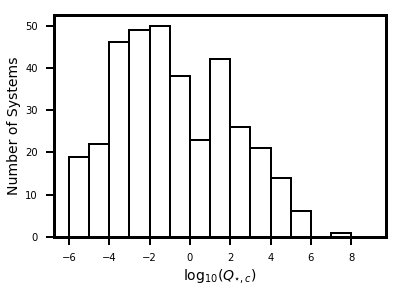

In [25]:
#reading in the dataframe produced when we use the mass radius relationship to compute mass
#for the change in period rather than assuming a 1 jup mass for all planets

old_df = pd.read_csv('HJ_df_final_radiusmass_relation.csv')
old_df = old_df[old_df['kepoi_name']  != 'K03794.01']
old_df = old_df[old_df['kepoi_name']  != 'K07430.01']
old_df = old_df[old_df['koi_prad'] <= 30]

plt.hist(old_df['crit_Q'].dropna(), np.arange(-6, 10, 1), edgecolor='k', linewidth=2.0, facecolor='w') 
plt.xlabel(r'$\log_{10}(Q_{\star, c})$', fontsize=14)
plt.ylabel('Number of Systems', fontsize=14)
plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.94, top=0.94, wspace=0.0, hspace=0.0)
plt.savefig('Q_star_hist_mass_radius_relation.png', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
#adding crit Q values from the 1 Jup mass assumption df to the old df(based on mass-radius relationship)
#this is for the sole purpose of having one dataset with all the information for the paper for each system
for index, row in old_df.iterrows():
    name = row['kepoi_name']
    #NOTE: tess uncert is the same as batman_transit_uncert but in minutes instead of days
    old_df.at[index, 'TESS_Uncert'] = (row['batman_transit_uncert'])*1440
    array = np.where(df_prob2['kepoi_name'] == name)
    new_row = df_prob2.iloc[array[0][0]]
    JupmassQ = new_row['crit_Q']
    old_df.at[index, 'Jup_mass_Q'] = JupmassQ

In [28]:
#making a HJ table for the paper and the machine readable table
table_for_paper = old_df[['kepoi_name', 'kepler_name', 'koi_period', 'koi_prad', 'koi_smass', 'tess_magnitude', 'Transit_uncert', 'TESS_Uncert', 'crit_Q']] #',Jup_mass_Q']]
table_for_paper.rename(columns={'Transit_uncert': 'Kepler_uncert'}, inplace=True)
table_for_paper = table_for_paper.sort_values(by=['kepoi_name'])
table_for_paper = table_for_paper.round({'koi_period':6, 'koi_smass': 2, 'tess_magnitude': 2, 'Kepler_uncert':2, 'TESS_Uncert':2, 'crit_Q':2, 'Jup_mass_Q':2})
table_for_paper = table_for_paper.drop(['tess_magnitude'], axis=1)
print(table_for_paper.head())
table_for_paper.to_csv('HJ_final_table.csv', index = False, header=None)

    kepoi_name kepler_name  koi_period  koi_prad  koi_smass  Kepler_uncert  \
1    K00001.01  Kepler-1 b    2.470613     13.04       0.97           0.06   
2    K00002.01  Kepler-2 b    2.204735     16.10       1.45           0.11   
132  K00003.01  Kepler-3 b    4.887803      4.82       0.83           0.52   
186  K00004.01         NaN    3.849372     12.94       1.48           3.31   
256  K00007.01  Kepler-4 b    3.213669      4.13       1.10           1.86   

     TESS_Uncert  crit_Q  
1            NaN    4.03  
2            NaN    5.06  
132          NaN    0.79  
186          NaN    3.76  
256          NaN    1.63  


In [ ]:
df_prob2.to_csv('HJ_df_final_all_Mjup_new_mass.csv')